In [7]:
from jedi import jedi

import matplotlib.pylab as plt
import numpy as np
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
# Target
target = lambda t0: cos(2 * pi * t0 / 50)

In [9]:
# Setting Seeds
seeds = uniform(0,10000,10).astype(int)

In [57]:
# Simulation Parameters for FORCE/DFORCE

dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 300      # size of stochastic pool
lr = 1.0     # learning rate

def set_simulation_parameters(seed):
    prng = np.random.RandomState(seed)

    J = prng.normal(0, sqrt(1 / N), (N, N))
    x0 = prng.uniform(-0.5, 0.5, N)

    u = prng.uniform(-1, 1, N)
    w = prng.uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # Initial weights

    return J, x0, u, w

In [85]:
# Printers

def mean_signal_error(errs, t, tstop, title, burn_in=0, mean=True):
    plt.figure(figsize=(8,6))
    if mean:
        errs = np.mean(errs, axis=0)
    ymax = 2*np.max(errs[burn_in:])
    print ymax
    plt.plot(t[burn_in:], errs[burn_in:], label="Signal/Output Error")
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.title(title)
    plt.legend()
    
def cross_mean_signal_error(errs1, errs2, t, tstop, title, burn_in=0):
    plt.figure(figsize=(8,6))
    errs1 = np.mean(errs1, axis=0)
    errs2 = np.mean(errs2, axis=0)
    ymax = 2*np.max([np.max(errs1[burn_in:]), np.max(errs2[burn_in:])])
    print ymax
    plt.plot(t[burn_in:], errs1[burn_in:], label="S/O Error (FORCE)", alpha=.8)
    plt.plot(t[burn_in:], errs2[burn_in:], label="S/O Error (DFORCE)", alpha=.8)
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.title(title)
    plt.legend()

In [62]:
errors = []

for seed in seeds:
    J, x0, u, w = set_simulation_parameters(seed)
    
    def model(t0, x, tanh_x, w): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u
    
    x,t,z,_,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

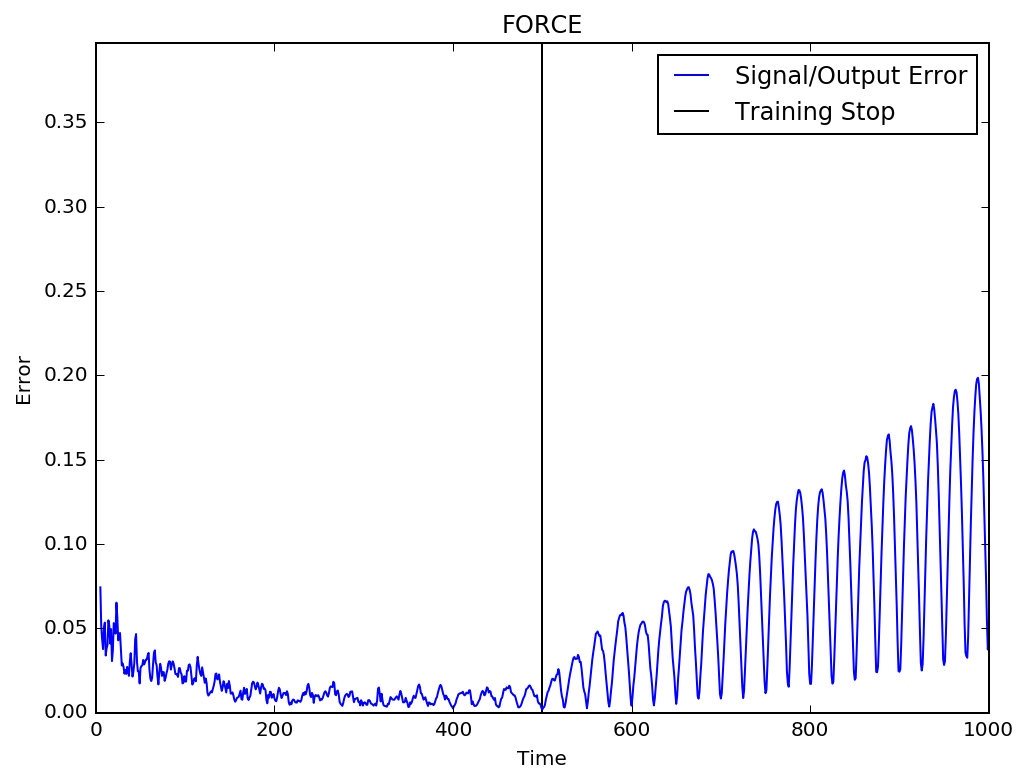

In [69]:
mean_signal_error(errors, t, tstop, title= "FORCE", burn_in=5)

In [64]:
# Simulation Parameters for DFORCE
lr = .4
rho = repeat(0.05, N)

In [65]:
derrors = []

for seed in seeds:
    J, x0, u, w = set_simulation_parameters(seed)
    
    def model(t0, x, tanh_x, w): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u
    
    x,t,z,_,_ = jedi.dforce(rho, target, model, lr, dt, tmax, tstop, x0, w)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

1.23045881406


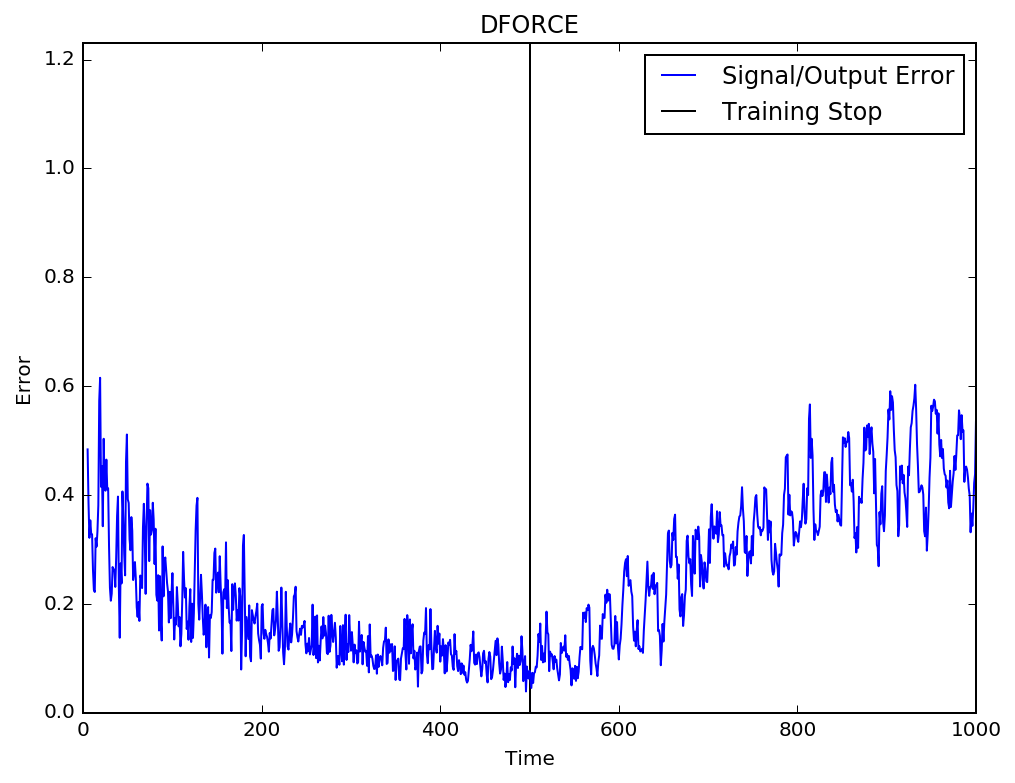

In [82]:
mean_signal_error(derrors, t, tstop, title="DFORCE", burn_in=5)

1.23045881406


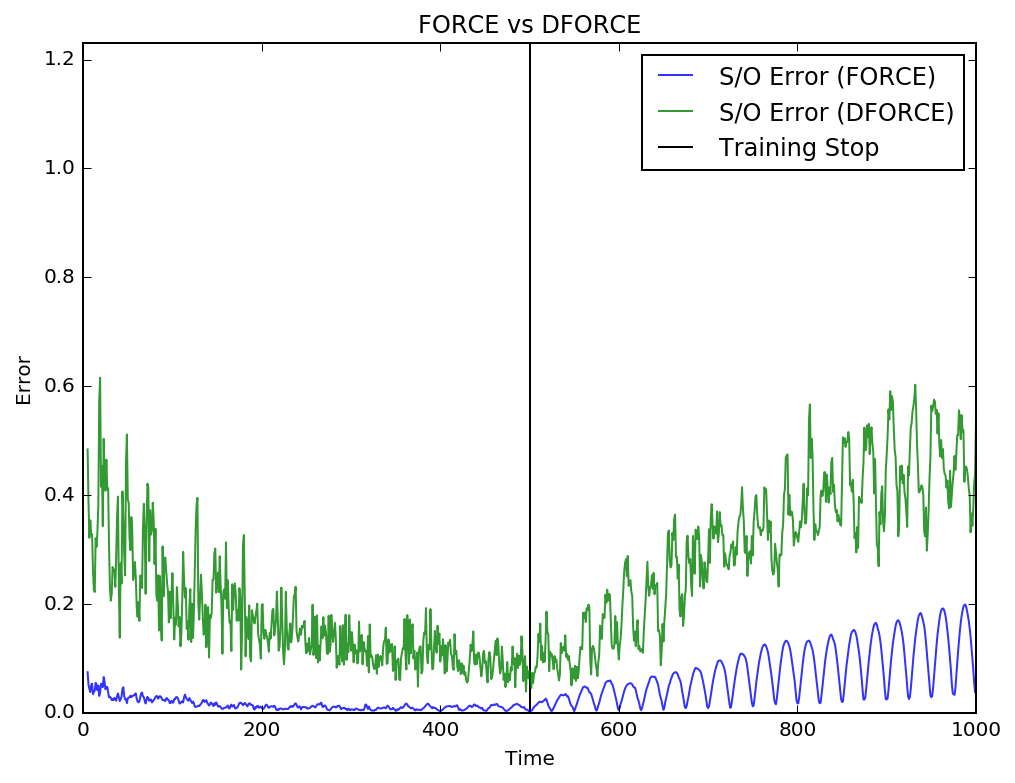

In [84]:
cross_mean_signal_error(errors, derrors, t, tstop, title="FORCE vs DFORCE", burn_in=5)